# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [62]:
import math
#import numpy as np
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [63]:
#These files are taken from examples/g2o.ipynb and examples/Helper Code.ipynb

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def nextPose(x, y, theta, delta_x, delta_y, delta_theta):
    x_next = x + delta_x * jnp.cos(theta) - delta_y * jnp.sin(theta)
    y_next = y + delta_y * jnp.cos(theta) + delta_x * jnp.sin(theta)
    theta_next = theta + delta_theta
    return jnp.array([x_next, y_next, theta_next])

def poses_to_string(poses):
    
    #Converting poses to string and defining it as per notation:
    posesString = []
    row=0
    for i in poses:
        s = "VERTEX_SE2"+" "+str(row)+" "+str(i[0])+" "+str(i[1])+" "+str(i[2])
        row+=1
        posesString.append(s)
    
    return posesString

In [64]:
#Read and store vertices(poses)
init_pose = readVertex("../data/edges.txt") #There is only one pose initially
init_pose = init_pose.reshape(1,-1)

#Read and store edges(odometry and loop-constraint)
ind1_arr,ind2_arr,del_x,del_y,del_theta = readEdge("../data/edges.txt")
edges = jnp.c_[ind1_arr,ind2_arr,del_x,del_y,del_theta]

poses = jnp.array(init_pose)
latest_pose = init_pose

#Traverse through all the edges and keep finding pose k+1 corresponding to edge k
for i in edges:

    #Ignore loop-constraint
    if i[0]+1!=i[1]:        
        continue

    x_k = latest_pose[0,0]
    y_k = latest_pose[0,1]
    theta_k = latest_pose[0,2]

    #Update according to motion model
    x_k1 = x_k + i[2]*jnp.cos(theta_k) - i[3]*jnp.sin(theta_k) 
    y_k1 = y_k + i[3]*jnp.cos(theta_k) + i[2]*jnp.sin(theta_k) 
    theta_k1 = theta_k + i[4]

    latest_pose = jnp.array([[x_k1,y_k1,theta_k1]])
    poses = jnp.vstack((poses,latest_pose))      #add row correspondint to (k+1)th pose 

print(jnp.shape(poses))
print(jnp.shape(edges))

(120, 3)
(139, 5)


In [66]:
#Now we will create and save the file edges-poses.txt
posesString = poses_to_string(poses)

#First deleting any previous occurence of the file
os.system('rm ../data/edges-poses.txt')

#After creating edges-poses.txt, append poses info to it.
for i in posesString:
    file_object = open("../data/edges-poses.txt", 'a')
    file_object.write(i)
    file_object.write('\n')
file_object.close()

#Now open and read edges.txt file (and ignore the initial VERTEX_SE2 row), then append edges.txt to edges-pose.txt
with open("../data/edges.txt", "r") as f:
    lines = f.readlines()
with open("../data/edges-poses.txt","a") as f:
    for line in lines:
        if line.strip("\n") != "VERTEX_SE2 0 -5.0 -8.0 0.0":
            f.write(line)

#Converting to g2o file
os.system('cp ../data/edges-poses.txt ../data/edges-poses.g2o')

0

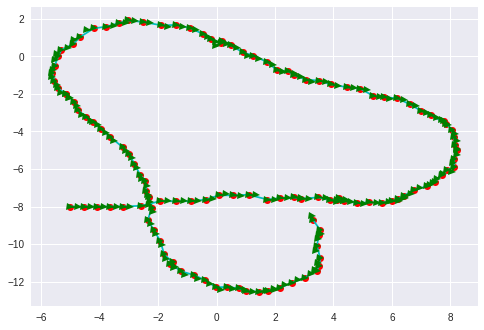

In [67]:
#Finally drawing:
draw(poses[:,0],poses[:,1],poses[:,2])

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [68]:
#Functions:

def residual(poses,edges,anchor):
    
    f_x = [poses[0,0]-anchor[0],poses[0,1]-anchor[1],poses[0,2]-anchor[2]]

    for edge in edges:
        #print("In RES")
        #print(edge)
        x = poses[int(edge[0]),0]
        y = poses[int(edge[0]),1]
        theta = poses[int(edge[0]),2]
        del_x = edge[2]
        del_y = edge[3]
        del_theta = edge[4]

        est = nextPose(x,y,theta,del_x,del_y,del_theta)
        
        f_x.append(est[0]-poses[int(edge[1]),0])
        f_x.append(est[1]-poses[int(edge[1]),1])
        f_x.append(est[2]-poses[int(edge[1]),2])

    return jnp.asarray(f_x)

def Jacobian_inbuilt(poses,edges,anchor):
    get_jacobian = jax.jacfwd(residual, argnums=0)
    J = get_jacobian(poses, edges, anchor)
    J = J.reshape((420, -1, 1))[:, :, 0]
    return J

def Information_Matrix(edges,informationOdometry,informationLoopConst,informationAnchor):

    diagonalEntries = [informationAnchor,informationAnchor,informationAnchor]

    for edge in edges:
        ##print("In IM")
        #print(edge)
        if edge[0]+1==edge[1]:
            diagonalEntries.append(informationOdometry)
            diagonalEntries.append(informationOdometry)
            diagonalEntries.append(informationOdometry)
        else:
            diagonalEntries.append(informationLoopConst)
            diagonalEntries.append(informationLoopConst)
            diagonalEntries.append(informationLoopConst)
    
    infoMatrix = jnp.diag(jnp.array(diagonalEntries))
    return infoMatrix

def get_error(poses, edges, anchor, informationMatrix):
    res = residual(poses, edges, anchor)
    error = 0.5 * res.T @ informationMatrix @ res
    return error

In [69]:
def Jacobian_Analytical(poses,edges,anchor):

    dim1 = 3*jnp.shape(edges)[0]+3   
    dim2 = 3*jnp.shape(poses)[0]

    J = jnp.zeros((dim1,dim2))    

    #Updating Jacobian w.r.t Anchor 
    J = J.at[0,0].set(1)      #w.r.t. x0
    J = J.at[1,1].set(1)      #w.r.t. y0
    J = J.at[2,2].set(1)     #w.r.t. theta_0

    for rows in range(jnp.shape(edges)[0]):
        
        edge = edges[rows]
        
        theta_i = poses[int(edge[0]),2]
        del_x = edge[2]
        del_y = edge[3]
        del_theta = edge[4]
        
        i, j = int(edge[0]), int(edge[1])
        J_row = 3*rows+3

        #Updating Jacobian w.r.t i_th pose:
        J_column_i = 3*i      #First Column corresponding to pose 'i'       
        J = J.at[J_row,J_column_i].set(1)                           #Updating x_i
        J = J.at[J_row+1,J_column_i+1].set(1)                       #Updating y_i
        J = J.at[J_row+2,J_column_i+2].set(1)                       #Updating theta_i    
        J = J.at[J_row,J_column_i+2].set(-del_x*jnp.sin(theta_i) - del_y*jnp.cos(theta_i))   #Updating theta_i
        J = J.at[J_row+1,J_column_i+2].set(-del_y*jnp.sin(theta_i) + del_x*jnp.cos(theta_i))   #Updating theta_i

        #Updating Jacobian w.r.t j_th pose:
        J_column_j = 3*j      #First Column corresponding to pose 'j'       
        J = J.at[J_row,J_column_j].set(-1)                          #Updating x_j
        J = J.at[J_row+1,J_column_j+1].set(-1)                          #Updating y_j
        J = J.at[J_row+2,J_column_j+2].set(-1)                          #Updating theta_j

    return J

In [70]:
def draw_all(X,Y,THETA):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax = plt.subplot(111)

    #Initial draw:
    initialPose = readVertex('../data/edges-poses.txt').T
    x_initial = initialPose[:,0]
    y_initial = initialPose[:,1]
    theta_initial = initialPose[:,2]
    
    ax.plot(x_initial, y_initial, 'ro')
    plt.plot(x_initial, y_initial, 'c-')
    for i in range(len(theta_initial)):
        x2 = 0.25*math.cos(theta_initial[i]) + x_initial[i]
        y2 = 0.25*math.sin(theta_initial[i]) + y_initial[i]
        plt.plot([x_initial[i], x2], [y_initial[i], y2], 'r->')

    
    #Ground Truth draw:
    gtPose = readVertex('../data/gt.txt').T
    
    x_gt = gtPose[:,0]
    y_gt = gtPose[:,1]
    theta_gt = gtPose[:,2]
    
    ax.plot(x_gt, y_gt, 'ro')
    plt.plot(x_gt, y_gt, 'c-')
    for i in range(len(theta_gt)):
        x2 = 0.25*math.cos(theta_gt[i]) + x_gt[i]
        y2 = 0.25*math.sin(theta_gt[i]) + y_gt[i]
        plt.plot([x_gt[i], x2], [y_gt[i], y2], 'b->')

    
    #Current pose draw:
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
    
    blue = mpatches.Patch(color='blue', label='Ground Truth')
    red = mpatches.Patch(color='red', label='Initial Pose')
    green = mpatches.Patch(color='green', label='Current Pose')
    plt.legend(handles=[blue,red,green])
    plt.show()


In [71]:
def LM(poses, edges, anchor, lm_lambda, tolerance, iterations, informationValues,display_step = 10):
    
    prev_poses = poses
    past_poses = [prev_poses]

    informationOdometry = informationValues[0]
    informationLoopConst = informationValues[1]
    informationAnchor = informationValues[2]
    informationMatrix = Information_Matrix(edges,informationOdometry,informationLoopConst,informationAnchor)
    
    past_errors = [get_error(prev_poses, edges, anchor, informationMatrix)]
    #draw_all(prev_poses[:, 0], prev_poses[:, 1], prev_poses[:, 2])

    for itr in range(1, iterations + 1):

        res = residual(prev_poses, edges, anchor)
        J =  Jacobian_inbuilt(prev_poses, edges,anchor)
        H = J.T @ informationMatrix @ J + lm_lambda * jnp.eye(J.shape[1])
        b = J.T @ informationMatrix.T @ res
        delta_poses = -jnp.linalg.inv(H) @ b
        delta_poses=delta_poses.reshape((-1,3))        
        
        cur_poses = prev_poses + delta_poses

        cur_error = get_error(cur_poses, edges, anchor, informationMatrix)
        print("The error value for interation ", itr, " came out to be : ", cur_error, "\n")

        #if itr % display_step == 0 or itr == iterations:
        draw_all(cur_poses[:, 0], cur_poses[:,1],cur_poses[:,2])
        
        if itr > 1:
            if cur_error > past_errors[-1]:
                lm_lambda *= 2
            else:
                lm_lambda /= 3

        cur_change = jnp.linalg.norm(cur_poses - prev_poses)

        if cur_change < tolerance:
            break

        past_poses.append(cur_poses)
        past_errors.append(cur_error)
        prev_poses = cur_poses
            
    return past_poses, past_errors

## Comparing Jacobians:

In [72]:
#Comparing Jacobian Analytical(calculated by us) vs Jacobian using jax()
anchor = poses[0, :]

J_inbuilt = Jacobian_inbuilt(poses,edges,anchor)
J_Analytical = Jacobian_Analytical(poses,edges,anchor)

Jacobian using jax auto differentiation ("theirs") has shape (420, 360)
Jacobian calculated analytically ("ours") has shape (420, 360)
Frobenius norm between is: 0.0


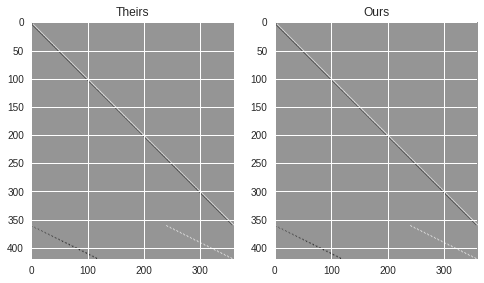

In [76]:
  

print('Jacobian using jax auto differentiation ("theirs") has shape', J_inbuilt.shape)
print('Jacobian calculated analytically ("ours") has shape', J_Analytical.shape)

#jnp.set_printoptions(suppress=True)
val = jnp.linalg.norm(J_inbuilt - J_Analytical, 'fro')
print(f"Frobenius norm between is: {val}")

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(J_inbuilt)
ax[0].set_title('Theirs')
ax[1].imshow(J_Analytical)
ax[1].set_title('Ours')
plt.show()

Jacobian using jax auto differentiation ("theirs") has shape (420, 360)
Jacobian calculated analytically ("ours") has shape (420, 360)
Frobenius norm between theirs and ours is: 0.0
None


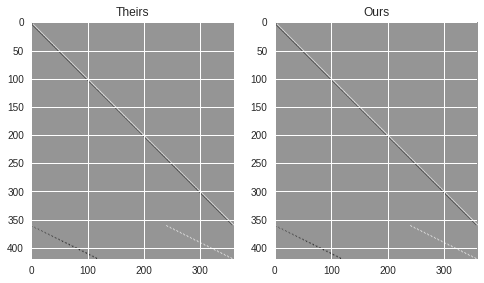

In [73]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

print('Jacobian using jax auto differentiation ("theirs") has shape', J_inbuilt.shape)
print('Jacobian calculated analytically ("ours") has shape', J_Analytical.shape)
print(frobNorm(J_inbuilt, J_Analytical, 'theirs', 'ours'))

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(J_inbuilt)
ax[0].set_title('Theirs')
ax[1].imshow(J_Analytical)
ax[1].set_title('Ours')
plt.show()

## Running the LM(Levenberg-Marquardt) alorithm for Pose Graph Optimisation

The error value for interation  1  came out to be :  142926.69 



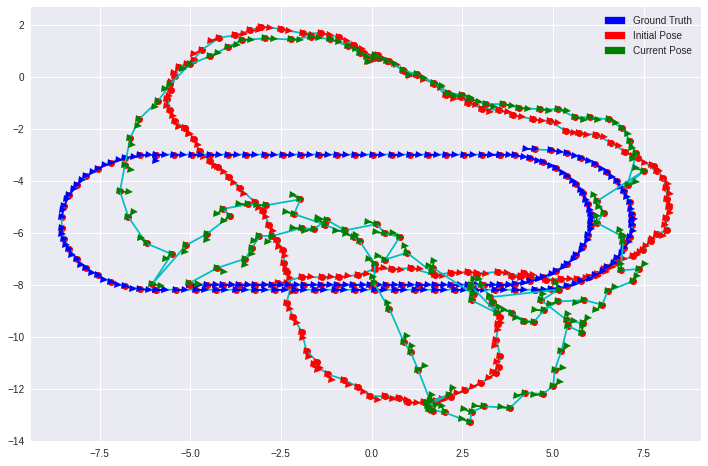

The error value for interation  2  came out to be :  924.8156 



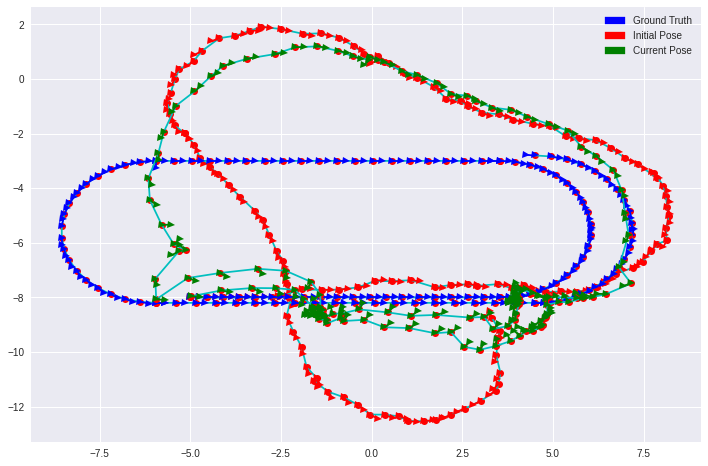

The error value for interation  3  came out to be :  344.01358 



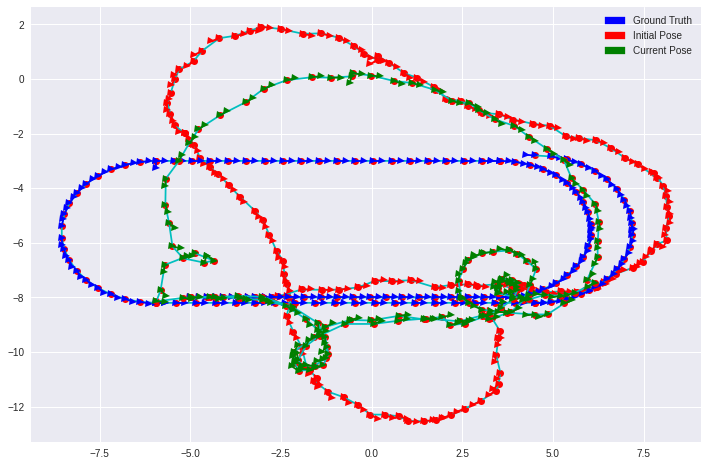

The error value for interation  4  came out to be :  186.59291 



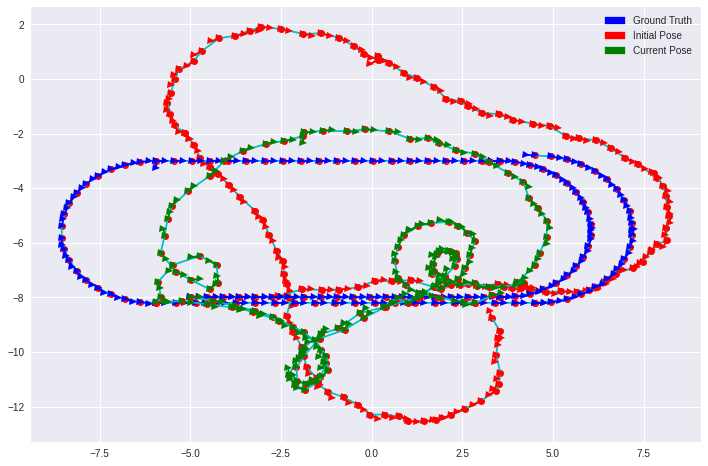

The error value for interation  5  came out to be :  148.12177 



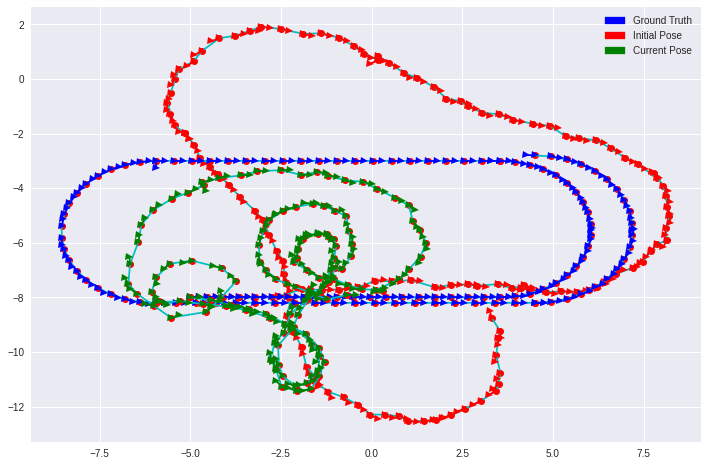

The error value for interation  6  came out to be :  492.80975 



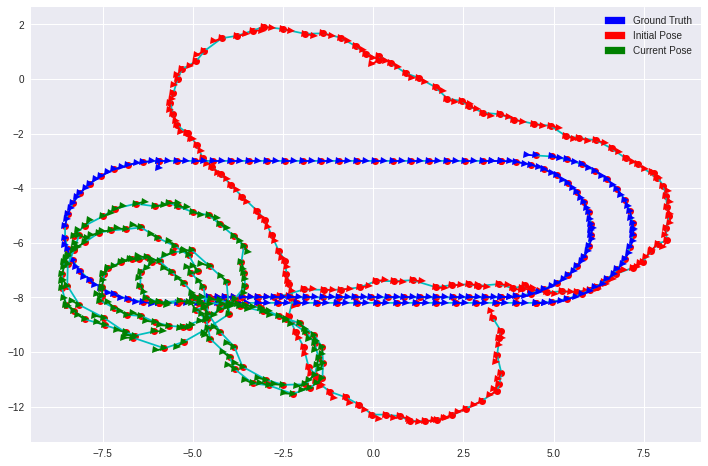

The error value for interation  7  came out to be :  71.00748 



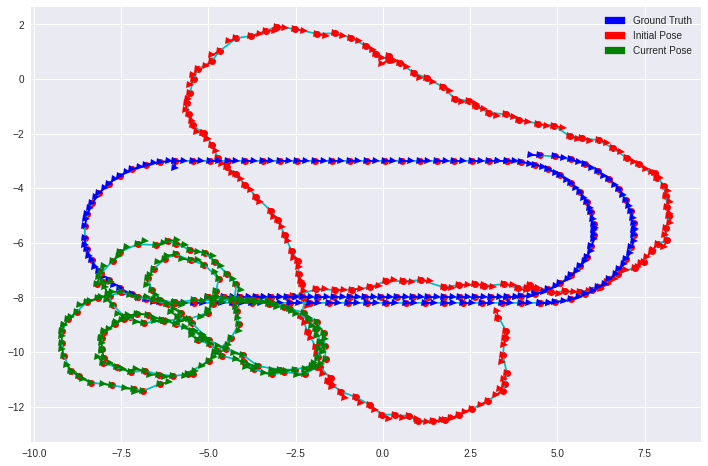

The error value for interation  8  came out to be :  154.99571 



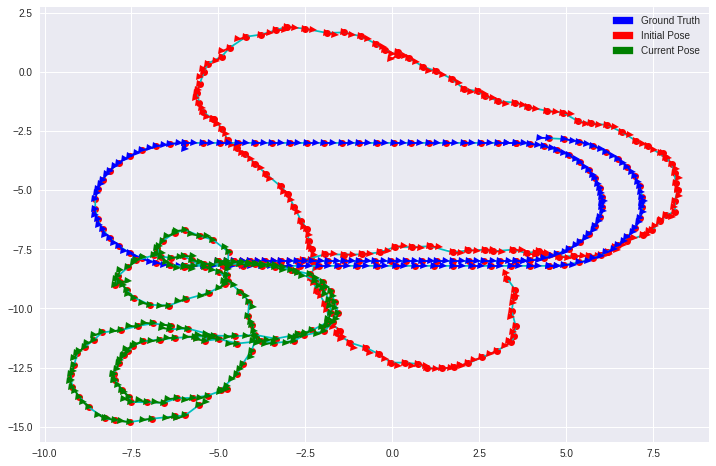

The error value for interation  9  came out to be :  67.26534 



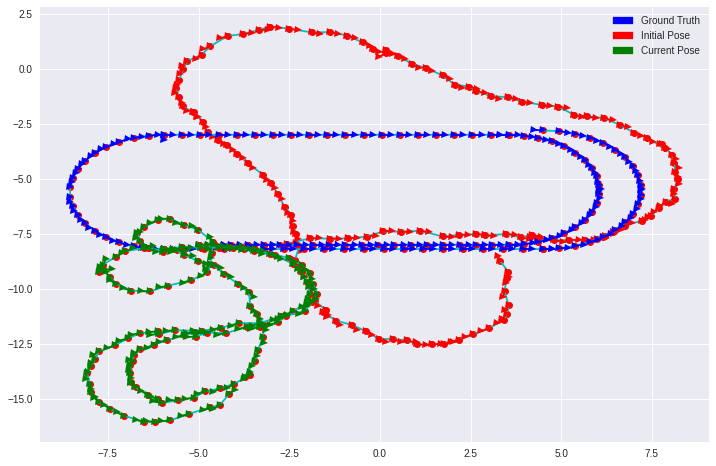

The error value for interation  10  came out to be :  162.29002 



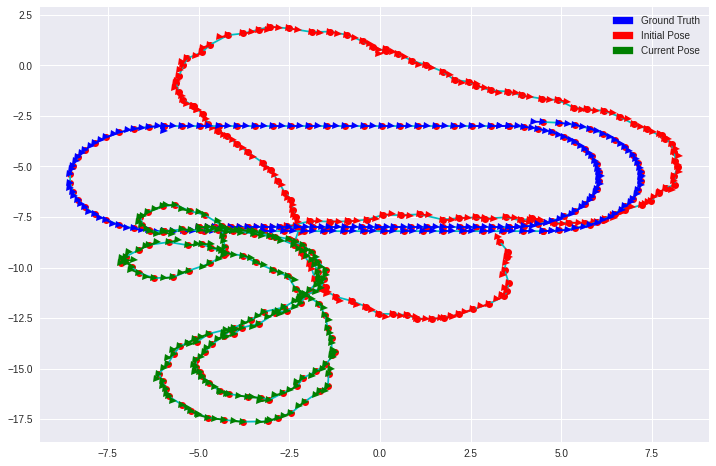

The error value for interation  11  came out to be :  63.24635 



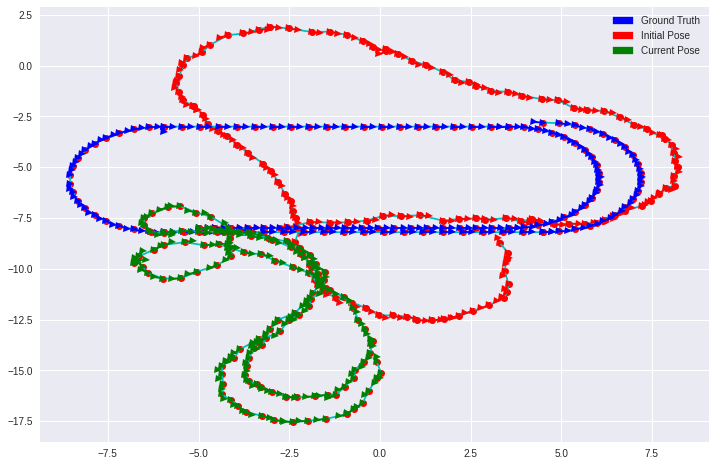

The error value for interation  12  came out to be :  161.05238 



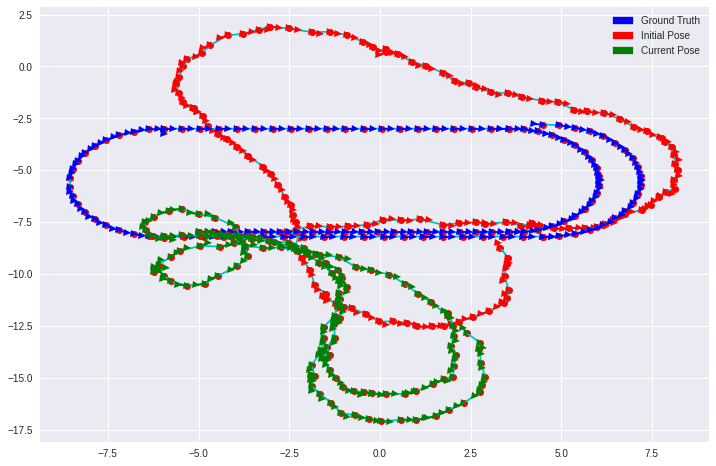

The error value for interation  13  came out to be :  51.07279 



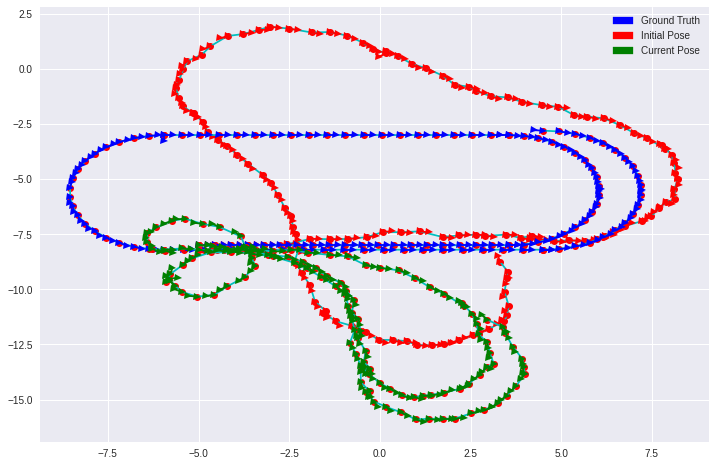

The error value for interation  14  came out to be :  117.31483 



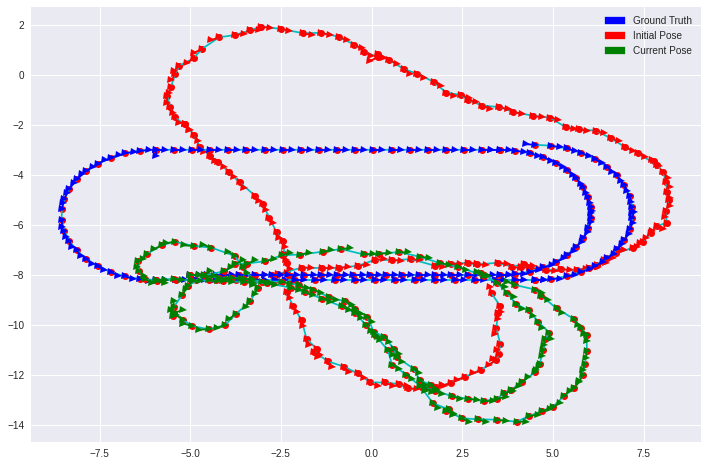

The error value for interation  15  came out to be :  37.72672 



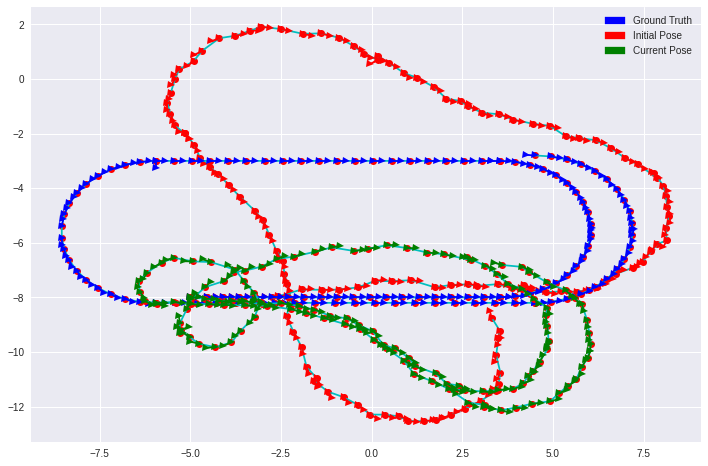

The error value for interation  16  came out to be :  63.234547 



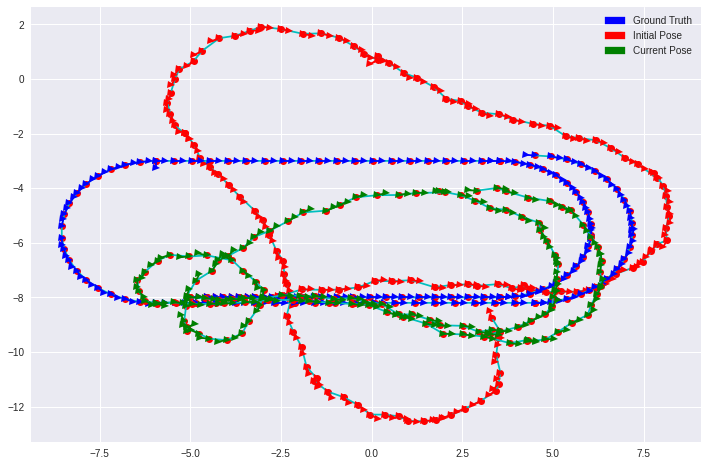

The error value for interation  17  came out to be :  29.050127 



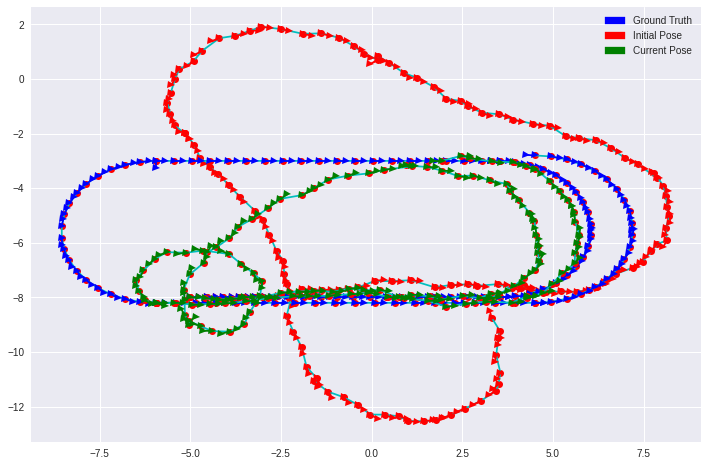

The error value for interation  18  came out to be :  33.056355 



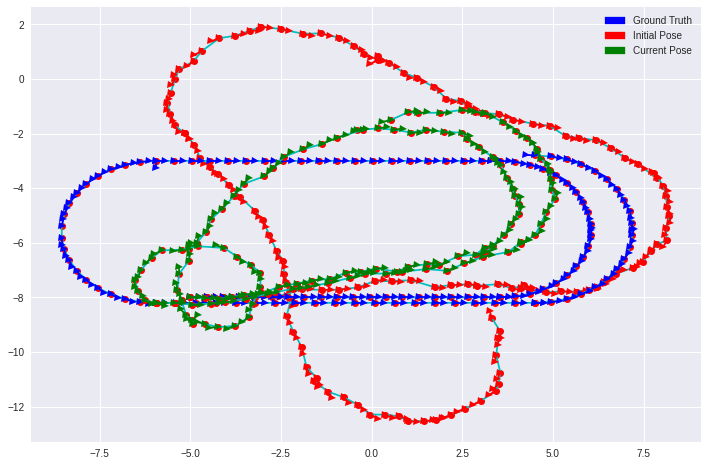

The error value for interation  19  came out to be :  25.419142 



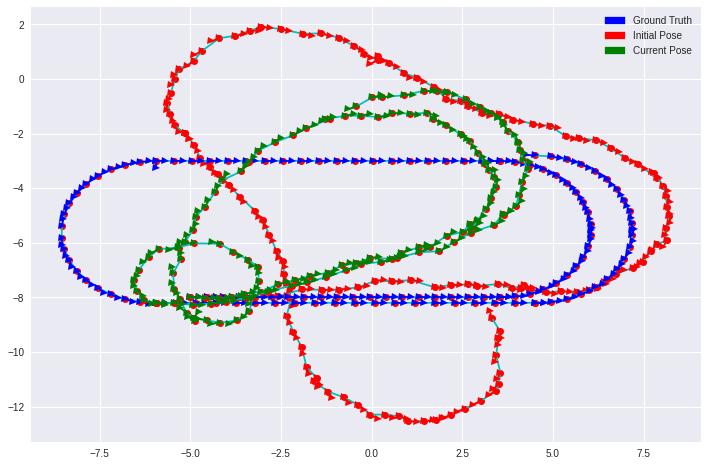

The error value for interation  20  came out to be :  25.399311 



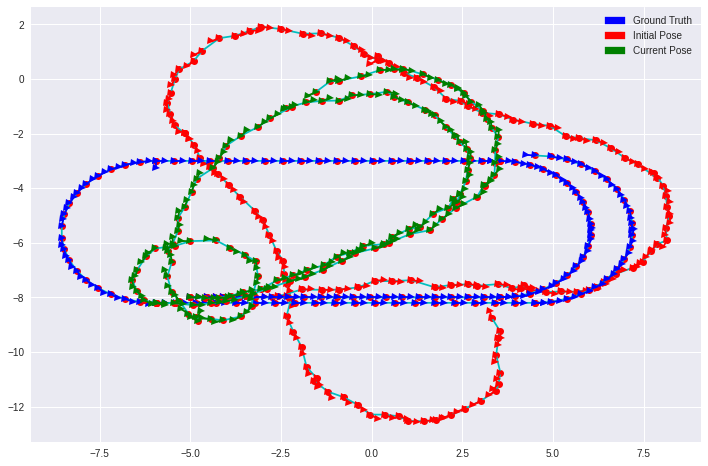

The error value for interation  21  came out to be :  24.48769 



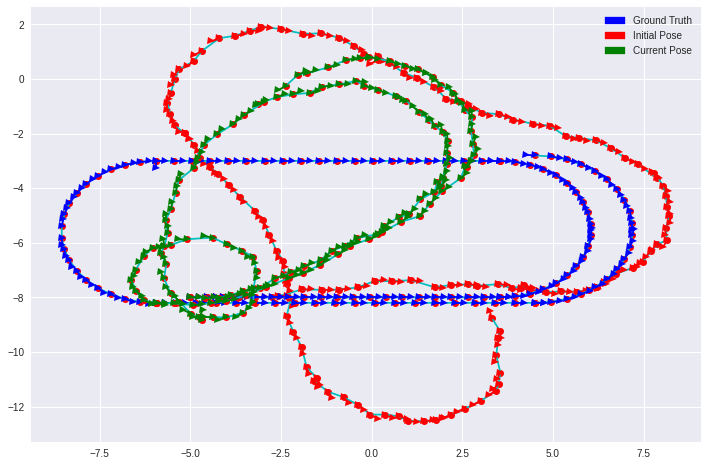

The error value for interation  22  came out to be :  24.216333 



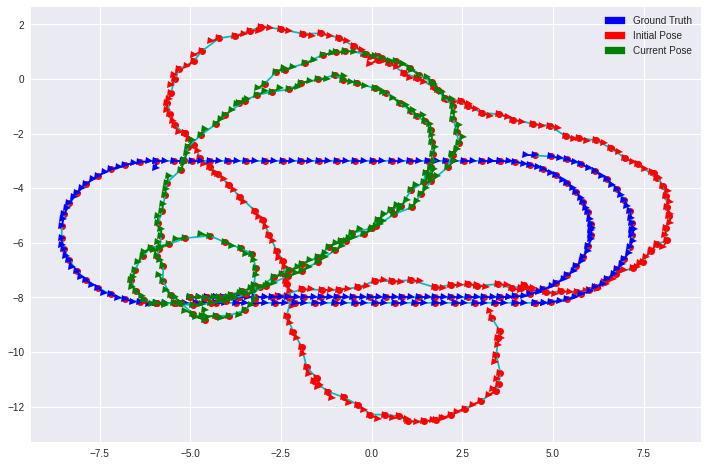

The error value for interation  23  came out to be :  24.136961 



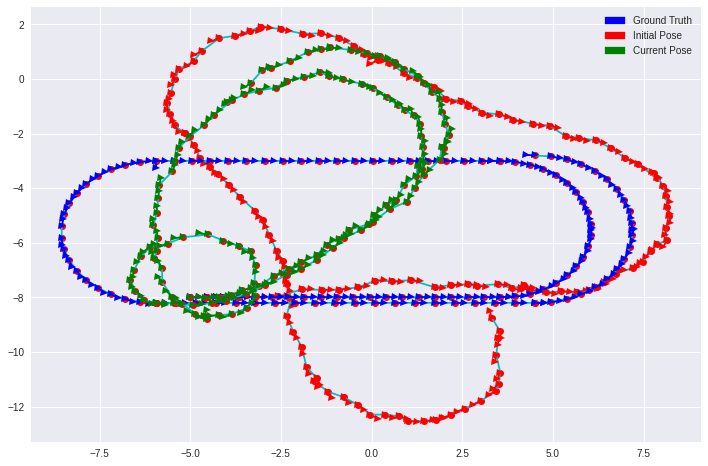

The error value for interation  24  came out to be :  24.112818 



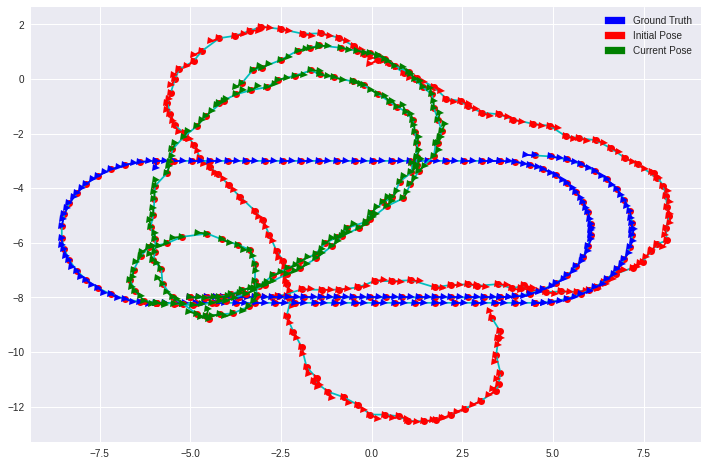

The error value for interation  25  came out to be :  24.104538 



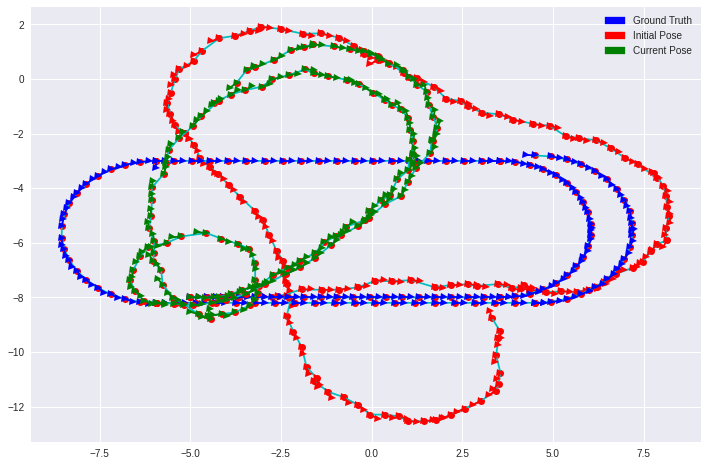

The error value for interation  26  came out to be :  24.10131 



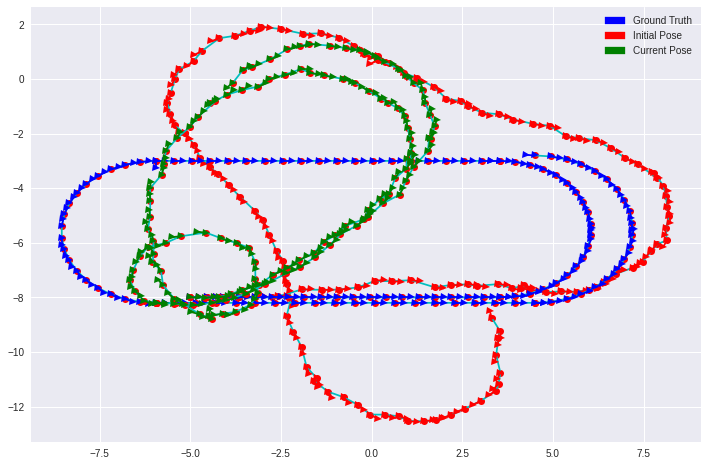

The error value for interation  27  came out to be :  24.099983 



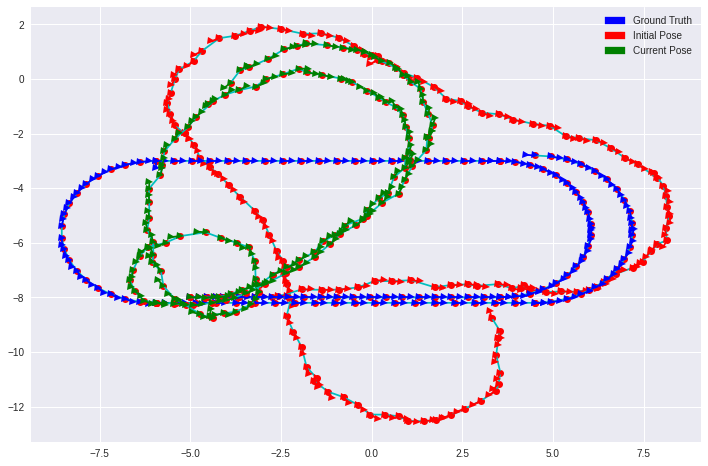

The error value for interation  28  came out to be :  24.09943 



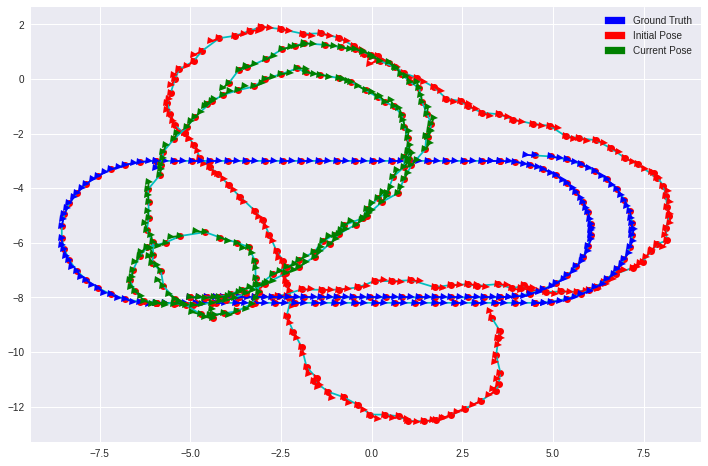

The error value for interation  29  came out to be :  24.099197 



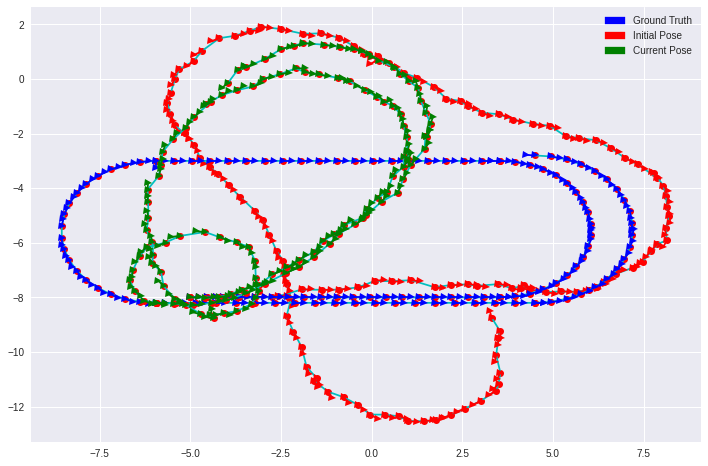

The error value for interation  30  came out to be :  24.099081 



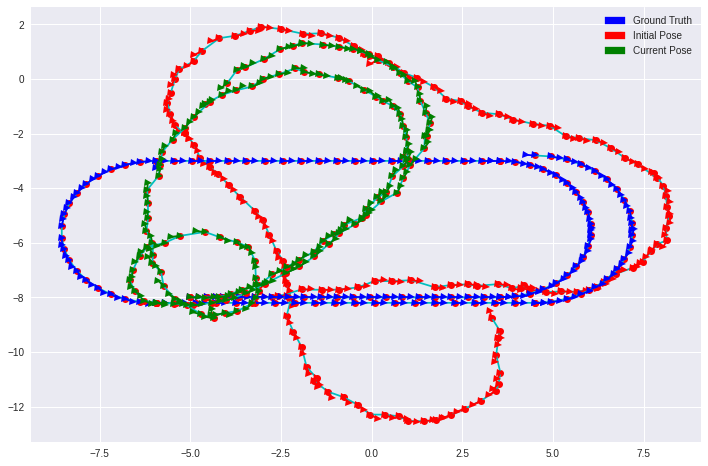

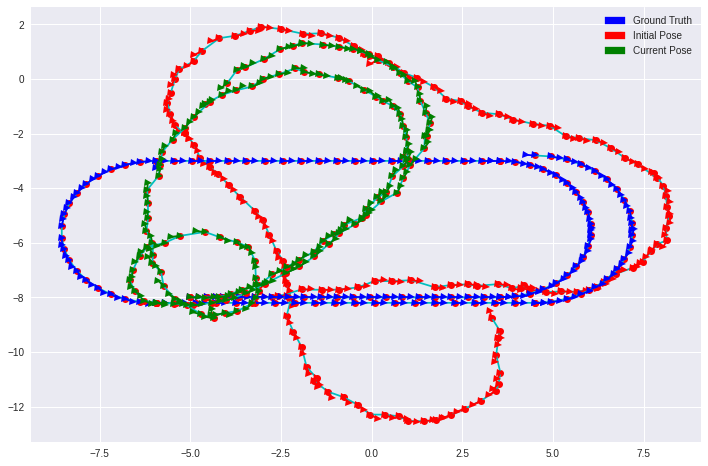

In [74]:
# Initial information values:
informationOdometry = 25
informationLoopConst = 1000
informationAnchor = 1200
informationValues = [informationOdometry,informationLoopConst,informationAnchor]

# Defining an anchor edges for the first pose of the graph with high information value so that it doesn't displace much after optimisation
anchor = poses[0, :]

# When to exit the loop:
iterations = 30
tolerance = 0.00001

# Dimensions of *poses* : N x 3

# Lambda value for LM:
lm_lambda = 1


collection_poses, collection_errors = LM(poses, edges, anchor, lm_lambda, tolerance, iterations,informationValues,display_step = 10)
optimal_index = jnp.argmin(jnp.asarray(collection_errors))
draw_all(collection_poses[optimal_index][:, 0], collection_poses[optimal_index][:, 1], collection_poses[optimal_index][:, 2])

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [75]:
bestPoses = collection_poses[optimal_index]
#Now we will create and save the file edges-poses-optimised.txt
posesString = poses_to_string(bestPoses)

#First deleting any previous occurence of the file
os.system('rm ../data/edges-poses-optimised.txt')

#After creating edges-poses.txt, append poses info to it.
for i in posesString:
    file_object = open("../data/edges-poses-optimised.txt", 'a')
    file_object.write(i)
    file_object.write('\n')
file_object.close()

#Now open and read edges.txt file (and ignore the initial VERTEX_SE2 row), then append edges.txt to edges-pose.txt
with open("../data/edges.txt", "r") as f:
    lines = f.readlines()
with open("../data/edges-poses-optimised.txt","a") as f:
    for line in lines:
        if line.strip("\n") != "VERTEX_SE2 0 -5.0 -8.0 0.0":
            f.write(line)

#Converting to g2o file
os.system('cp ../data/edges-poses-optimised.txt ../data/edges-poses-optimised.g2o')

0